In [1]:
import numpy as np
import pandas as pd
import librosa as lb
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

2024-05-01 11:54:21.235880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 11:54:21.236010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 11:54:21.369228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from warnings import filterwarnings
filterwarnings('ignore')

READ THE DATA

In [5]:
metadata = pd.read_csv('/kaggle/input/guitar-sounds/notes_v2/n_metadata.csv')
print(f'Samples num: {metadata.shape[0]}\nColumns num: {metadata.shape[1]}')
metadata.head()

Samples num: 234
Columns num: 3


,Sample,Class_ID,Class
0,./input/notes_v2/A/A1.wav,1,A
1,./input/notes_v2/A/A1.wav_000.wav,1,A
2,./input/notes_v2/A/A1.wav_010.wav,1,A
3,./input/notes_v2/A/A2.wav,1,A
4,./input/notes_v2/A/A2.wav_001.wav,1,A


**GETTNG INFO ABOUT THE CLASSES*

In [6]:
classes = metadata.groupby('Class_ID')['Class'].unique()
classes

Class_ID
1           [A]
2           [B]
3           [C]
4           [D]
5           [E]
6           [F]
7           [G]
8      [Barrel]
9       [Flage]
10    [PoffHon]
11       [Slap]
12      [Slide]
13    [Silence]
Name: Class, dtype: object

FUNCTON TO EXTRACT DATA FROM SAMPLES

In [27]:
def feature_extractor(path: str) -> np.array:
    data, sr = librosa.load(path)  # Load audio data and sampling rate
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=128)  # Pass data and sr to mfcc function
    chroma = librosa.feature.chroma_stft(y=data, sr=sr)
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=data)
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sr)
    
    features = np.concatenate((np.mean(mfccs, axis=1),
                                np.mean(chroma, axis=1),
                                np.mean(mel, axis=1),
                                np.mean(zero_crossing_rate, axis=1),
                                np.mean(spectral_centroid, axis=1),
                                np.mean(spectral_contrast, axis=1)))
    
    return features


DATA EXTRACTION

In [28]:
x, y = [], []

for i, rows in tqdm(metadata.iterrows()):
    path = rows['Sample']
    x.append(feature_extractor(f'/kaggle/input/guitar-sounds/{path[7:]}'))
    y.append(rows['Class_ID'])

x = np.array(x)
y = np.array(y)

x.shape, y.shape

234it [00:18, 12.55it/s]


((234, 277), (234,))

TRANSFERR OF TARGET CLASS TO CATEGORY CLASS

In [29]:
y = to_categorical(y)
y.shape

(234, 14)

SPLIT (TRAN/TEST/VAL)

In [30]:
xtrainval, xtest, ytrainval, ytest = train_test_split(x, y, test_size=0.1, stratify=y, random_state=42)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrainval, ytrainval, test_size=0.2, stratify=ytrainval,random_state=42)

print('\nNumber of samples for Train set :',xtrain.shape[0])
print('Number of samples for Validation set :',xvalid.shape[0])
print('Number of samples for Test set :',xtest.shape[0])


Number of samples for Train set : 168
Number of samples for Validation set : 42
Number of samples for Test set : 24


MODEL ARCHITECTURE

In [43]:
from tensorflow.keras import regularizers

model = Sequential(
    [
        layers.Dense(1024, activation='relu', input_shape=(277,), kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(14, activation='softmax')
    ]
)

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 1024)           │       284,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 984,494 (3.76 MB)

 Trainable params: 984,494 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

MODEL COMPILATIION AND TRAINNG 

In [45]:
from keras.callbacks import ReduceLROnPlateau

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define a learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with learning rate scheduler
training = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=80, callbacks=[reduce_lr])


Epoch 1/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 995ms/step - accuracy: 0.5454 - loss: 5.4867 - val_accuracy: 0.5714 - val_loss: 6.6428 - learning_rate: 0.0010
Epoch 2/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5165 - loss: 4.0991 - val_accuracy: 0.5000 - val_loss: 2.7764 - learning_rate: 0.0010
Epoch 3/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6180 - loss: 1.8895 - val_accuracy: 0.5238 - val_loss: 2.6697 - learning_rate: 0.0010
Epoch 4/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6738 - loss: 1.6670 - val_accuracy: 0.7619 - val_loss: 1.5696 - learning_rate: 0.0010
Epoch 5/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7902 - loss: 1.1701 - val_accuracy: 0.9048 - val_loss: 1.4323 - learning_rate: 0.0010
Epoch 6/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9151 - loss: 0.9108 - val_accuracy: 0.9286 - val_loss: 1.3847 - learning_rate: 0.0010
Epoch 7/80
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9617 - loss: 0.6997 - val_accuracy: 0.9524 - val

VERIFCATON OF RESULTS

In [46]:
train_hist = pd.DataFrame(training.history)
train_hist

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.434524,6.048599,0.571429,6.642789,0.0010
1,0.541667,3.345503,0.500000,2.776428,0.0010
2,0.648810,1.685596,0.523810,2.669680,0.0010
3,0.720238,1.463104,0.761905,1.569640,0.0010
4,0.803571,1.109717,0.904762,1.432348,0.0010
...,...,...,...,...,...
75,1.000000,0.388564,0.928571,1.064432,0.0001
76,1.000000,0.388155,0.928571,1.070938,0.0001
77,1.000000,0.387759,0.928571,1.068923,0.0001
78,1.000000,0.387358,0.928571,1.076202,0.0001


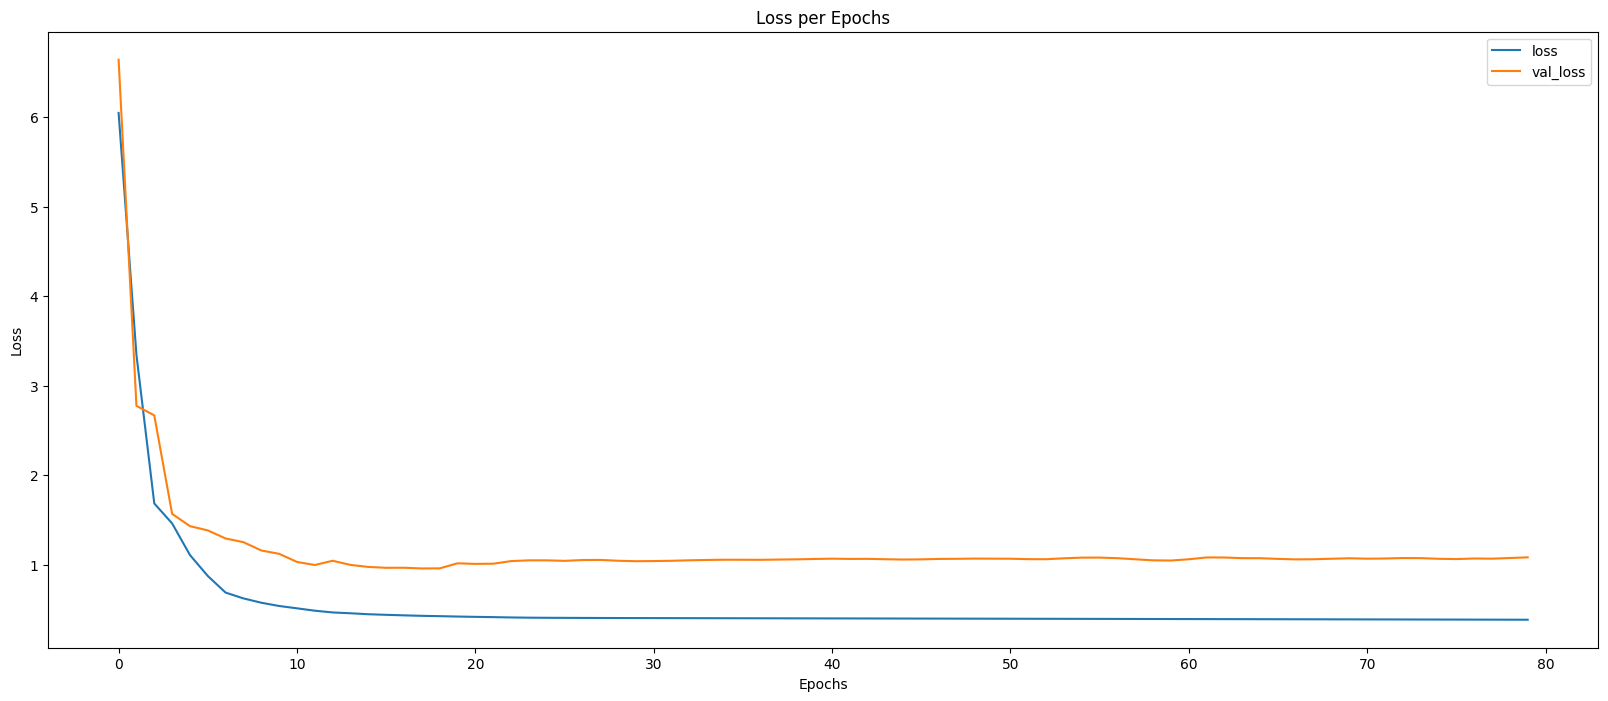

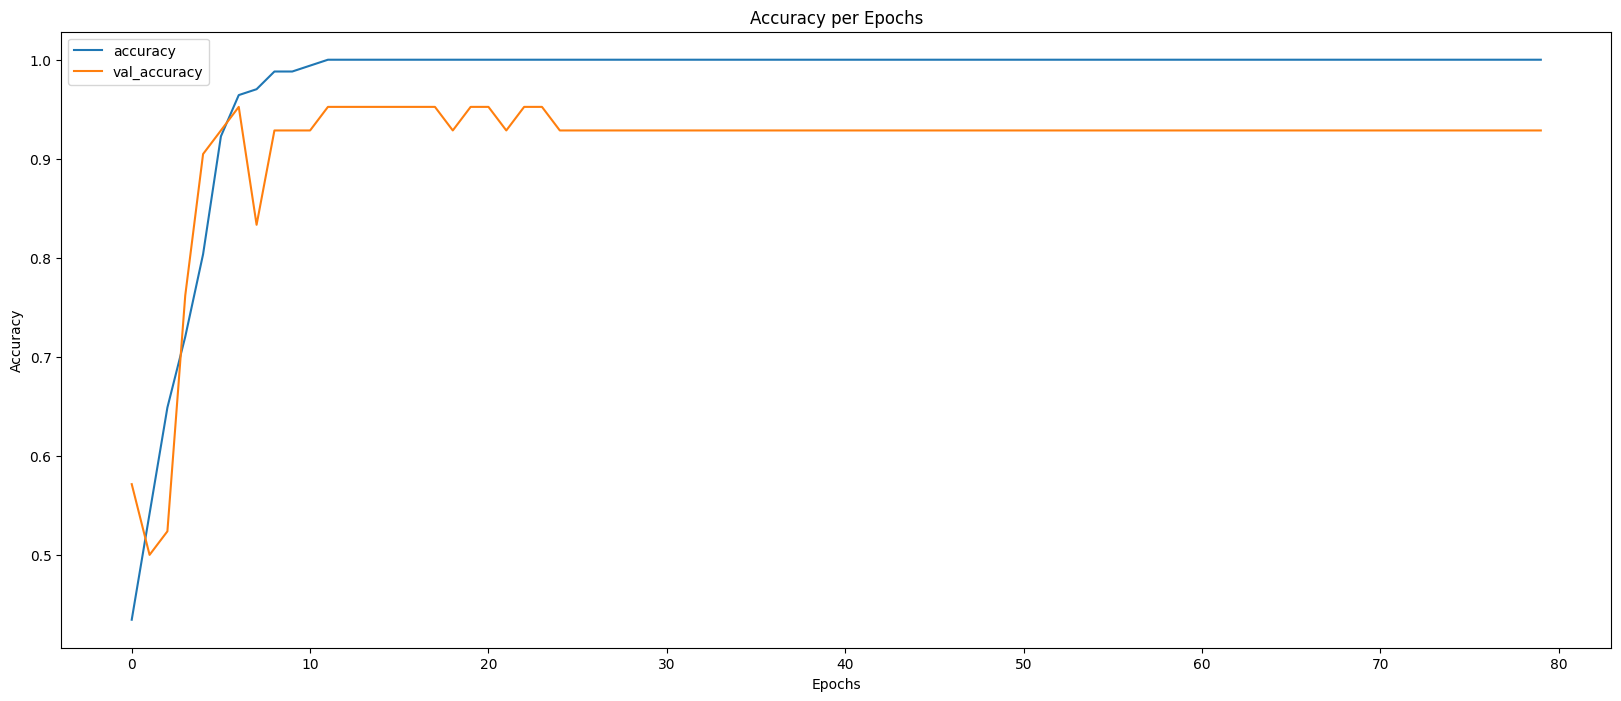

In [47]:
plt.figure(figsize=(20, 8))
plt.plot(train_hist[['loss', 'val_loss']])
plt.legend(['loss', 'val_loss'])
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(train_hist[['accuracy', 'val_accuracy']])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming y_true and y_pred are already defined
ytrue = np.argmax(ytest, axis=1)
ypred = np.argmax(model.predict(xtest), axis=1)

conf_matrix = confusion_matrix(ytrue, ypred)
print('\nConfusion Matrix:\n', conf_matrix)

class_report = classification_report(ytrue, ypred)
print('\nClassification Report:\n', class_report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step

Confusion Matrix:
 [[2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00        